# <span style="color:red">Projet Final : Kit Big Data</span>

In [1]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import cartopy.crs as ccrs
from bs4 import BeautifulSoup
import requests
import seaborn as sns


from sklearn.linear_model import LinearRegression
import matplotlib.lines as mlines



## <span style="color:red">Partie 1 & 2 : Acquisition, chargement des données (3 points) & Préparation des données (5 points)

In [2]:
# Le fichier excels est une copie local des fichier Excel du Vendée Globe

# crée une liste des noms des fichiers présent dans excels
filenames = [f for f in listdir("excels/") if isfile(join("excels/", f))]

In [3]:
# Met la liste dans le bon ordre
filenames.sort()

In [4]:
len(filenames)

703

## Concaténation des dataframes 

Le paterne des créations des df est fixes. Chaque jour est créé un fichier à 4h, 8h, 11h, 14h, 17h et 21h.
Nous concatenons tous les fichier dans l'ordre des jours. nous partirons du premier fichier en date du 11/08/2010 

!! Vers la fin de la course le format des fichiers Excel change avec les arrivées des voiliers : il est possible de s'arrêter juste avant. !!

In [5]:
def concat_df(filenames):
    df_init = pd.read_excel("excels/"+filenames[0])
    df_init = df_init.drop(df_init.columns[[0]], axis='columns')
    # On retire l'entête du excel et les 4 dernières lignes.
    df_init.drop(df_init.head(4).index,inplace=True)
    df_init.drop(df_init.tail(4).index, inplace=True)

    df_init['Jour'] = filenames[0][0:8]

    ###
    # Les 221 dernier fichier ayant un format differnt nous ne les prendrons pas
    ###
    
    for i in filenames[1:(len(filenames)-221)]:
        df = pd.read_excel("excels/"+i)
        # On retire l'entête du excel.
        df.drop(df.head(4).index,inplace=True)
        df = df.drop(df.columns[[0]], axis='columns')
        df.drop(df.tail(4).index, inplace=True)
        # On ajoute une colonne pour pouvoir retrouver le jour suite au retrait l'entête. 
        df['Jour'] = i[0:8]
        df_init = pd.concat([df_init, df])
        
    return df_init


In [6]:
df_concat = concat_df(filenames)

In [7]:
df_concat

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,...,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Jour
4,NaN,\nFRA 79,Charlie Dalin\nAPIVIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20201108
5,NaN,\nFRA 4,Sébastien Simon\nARKEA PAPREC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20201108
6,NaN,\nFRA 30,Clarisse Cremer\nBanque Populaire X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20201108
7,NaN,\nFRA 18,Louis Burton\nBureau Vallée 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20201108
8,NaN,\nFRA 50,Miranda Merron\nCampagne de France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20201108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,RET,\nFRA 109,Samantha Davies\nInitiatives - Coeur,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20210127
33,RET,\nFRA 4,Sébastien Simon\nARKEA PAPREC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20210127
34,RET,\nGBR 99,Alex Thomson\nHUGO BOSS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20210127
35,RET,\nFRA 85,Kevin Escoffier\nPRB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20210127


On obsere que certain concurent sont defini comme 'RET' dans le rang.

On verra par la suite qu'il s'agit des participants ayant abandonnés.

### Fonction de nettoyage et d'organisation des données : 

In [8]:
def reorga(df):

    # On rename
    df.columns = ['Rang', 'Nationalite', 'Skipper', 'Heure',
                'Latitude', 'Longitude', 'Cap Depuis 30 min (deg)',
                'Vitesse Depuis 30 min (kts)', 'VMG Depuis 30 min (kts)',
                'Distance Depuis 30 min (nm)', 'Cap Depuis le dernier classement (deg)',
                'Vitesse Depuis le dernier classement (kts)', 'VMG Depuis le dernier classement (kts)',
                'Distance Depuis le dernier classement (nm)', 'Cap Depuis 24h (deg)',
                'Vitesse Depuis 24h (kts)', 'VMG Depuis 24h (kts)',
                'Distance Depuis 24h (nm)', 'DTF (nm)', 'DTL (nm)', 'Jour']
    # On retire les valeurs na
    df = df.dropna()
    
    # On séparre le nom du bateau et le skipper.
    df['Bateau'] = df['Skipper'].apply(lambda x : str(x.split('\n')[1].upper())).astype(str)
    df['Skipper'] = df['Skipper'].apply(lambda x : str(x.split('\n')[0].upper())).astype(str)
    # On séparre la Nationnalité et le numéro d'identification.
    df['Identifiant'] = df['Nationalite'].apply(lambda x: str(x.split('\n')[1].upper())).apply(lambda x: str(x.split(' ')[1].upper())).astype(str)
    df['Nationalite'] = df['Nationalite'].apply(lambda x: str(x.split('\n')[1].upper())).apply(lambda x: str(x.split(' ')[0].upper())).astype(str)
    # On ne garde que l'heure.
    df['Heure'] = df['Heure'].apply(lambda x : str(x.split(' ')[0])).astype(str)

    #On retire toutes les unités des valeurs.
    df['Cap Depuis 30 min (deg)'] = df['Cap Depuis 30 min (deg)'].apply(lambda x : x[:-1]).astype(int)
    df['Vitesse Depuis 30 min (kts)'] = df['Vitesse Depuis 30 min (kts)'].apply(lambda x : x.split(' ')[0]).astype(float)
    df['VMG Depuis 30 min (kts)'] = df['VMG Depuis 30 min (kts)'].apply(lambda x : x.split(' ')[0]).astype(float)
    df['Distance Depuis 30 min (nm)'] = df['Distance Depuis 30 min (nm)'].apply(lambda x : x.split(' ')[0]).astype(float)
    df['Cap Depuis le dernier classement (deg)'] = df['Cap Depuis le dernier classement (deg)'].apply(lambda x : x[:-1]).astype(int)
    df['Vitesse Depuis le dernier classement (kts)'] = df['Vitesse Depuis le dernier classement (kts)'].apply(lambda x : x.split(' ')[0]).astype(float)
    df['VMG Depuis le dernier classement (kts)'] = df['VMG Depuis le dernier classement (kts)'].apply(lambda x : x.split(' ')[0]).astype(float)
    df['Cap Depuis 24h (deg)'] = df['Cap Depuis 24h (deg)'].apply(lambda x : x[:-1]).astype(int)
    df['Distance Depuis 24h (nm)'] = df['Distance Depuis 24h (nm)'].apply(lambda x : x.split(' ')[0]).astype(float)
    df['Vitesse Depuis 24h (kts)'] = df['Vitesse Depuis 24h (kts)'].apply(lambda x : x.split(' ')[0]).astype(float)
    df['VMG Depuis 24h (kts)'] = df['VMG Depuis 24h (kts)'].apply(lambda x : x.split(' ')[0]).astype(float)
    df['Distance Depuis le dernier classement (nm)'] = df['Distance Depuis le dernier classement (nm)'].apply(lambda x : x.split(' ')[0]).astype(float)
    df['DTF (nm)'] = df['DTF (nm)'].apply(lambda x : x.split(' ')[0]).astype(float)
    df['DTL (nm)'] = df['DTL (nm)'].apply(lambda x : x.split(' ')[0]).astype(float)

    # Ajout d'une colonne Temps
    df["Temps"] = pd.to_datetime(df["Jour"]+df["Heure"].apply(lambda x : x[0:2]+x[3:5]), format='%Y%m%d%H%M')

    # On reset l'index
    df.reset_index(drop = True, inplace=True)

    # On reindexe no colonne pour la lisibilité
    df = df.reindex(columns= ['Temps', 'Rang', 'Identifiant', 'Skipper',
                'Latitude', 'Longitude', 'Cap Depuis 30 min (deg)',
                'Vitesse Depuis 30 min (kts)', 'VMG Depuis 30 min (kts)',
                'Distance Depuis 30 min (nm)', 'Cap Depuis le dernier classement (deg)',
                'Vitesse Depuis le dernier classement (kts)', 'VMG Depuis le dernier classement (kts)',
                'Distance Depuis le dernier classement (nm)', 'Cap Depuis 24h (deg)',
                'Vitesse Depuis 24h (kts)', 'VMG Depuis 24h (kts)',
                'Distance Depuis 24h (nm)', 'DTF (nm)', 'DTL (nm)','Bateau', 'Nationalite', 'Jour', 'Heure'])
    
    df['Rang'] = df['Rang'].astype(int)

    
    return df

In [9]:
pd.options.mode.chained_assignment = None  # default='warn'

In [10]:
df_new = reorga(df_concat)

In [11]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13678 entries, 0 to 13677
Data columns (total 24 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   Temps                                       13678 non-null  datetime64[ns]
 1   Rang                                        13678 non-null  int64         
 2   Identifiant                                 13678 non-null  object        
 3   Skipper                                     13678 non-null  object        
 4   Latitude                                    13678 non-null  object        
 5   Longitude                                   13678 non-null  object        
 6   Cap Depuis 30 min (deg)                     13678 non-null  int64         
 7   Vitesse Depuis 30 min (kts)                 13678 non-null  float64       
 8   VMG Depuis 30 min (kts)                     13678 non-null  float64       
 9   Distan

In [12]:
df_new.head(31)

,Temps,Rang,Identifiant,Skipper,Latitude,Longitude,Cap Depuis 30 min (deg),Vitesse Depuis 30 min (kts),VMG Depuis 30 min (kts),Distance Depuis 30 min (nm),...,Cap Depuis 24h (deg),Vitesse Depuis 24h (kts),VMG Depuis 24h (kts),Distance Depuis 24h (nm),DTF (nm),DTL (nm),Bateau,Nationalite,Jour,Heure
0,2020-11-08 15:30:00,1,18,LOUIS BURTON,46°24.46'N,01°50.48'W,241,17.7,17.5,0.3,...,201,0.3,0.3,6.1,24293.9,0.0,BUREAU VALLÉE 2,FRA,20201108,15:30
1,2020-11-08 15:31:00,2,10,BORIS HERRMANN,46°24.34'N,01°49.82'W,241,11.1,10.9,0.4,...,196,0.3,0.2,6.0,24294.2,0.4,SEAEXPLORER - YACHT CLUB DE MONACO,MON,20201108,15:31
2,2020-11-08 15:30:00,3,8,JÉRÉMIE BEYOU,46°24.91'N,01°49.99'W,244,15.5,15.5,0.5,...,199,0.2,0.2,5.5,24294.3,0.5,CHARAL,FRA,20201108,15:30
3,2020-11-08 15:30:00,4,59,THOMAS RUYANT,46°24.71'N,01°49.68'W,244,13.2,13.1,0.7,...,196,0.2,0.2,5.6,24294.5,0.6,LINKEDOUT,FRA,20201108,15:30
4,2020-11-08 15:30:00,5,53,MAXIME SOREL,46°24.59'N,01°49.56'W,246,10.9,10.9,0.2,...,195,0.8,0.7,5.8,24294.5,0.6,V AND B MAYENNE,FRA,20201108,15:30
5,2020-11-08 15:31:00,6,56,FABRICE AMEDEO,46°25.19'N,01°49.87'W,238,16.9,16.9,0.6,...,200,0.2,0.2,5.3,24294.5,0.7,NEWREST - ART ET FENETRES,FRA,20201108,15:31
6,2020-11-08 15:30:00,7,01,JEAN LE CAM,46°24.90'N,01°49.49'W,247,10.7,10.7,0.2,...,196,0.2,0.2,5.5,24294.7,0.8,YES WE CAM !,FRA,20201108,15:30
7,2020-11-08 15:30:00,8,99,ALEX THOMSON,46°25.21'N,01°49.45'W,238,13.8,13.7,1.1,...,196,0.2,0.2,5.2,24294.8,1.0,HUGO BOSS,GBR,20201108,15:30
8,2020-11-08 15:31:00,9,69,SÉBASTIEN DESTREMAU,46°25.04'N,01°49.32'W,245,9.6,9.6,0.3,...,195,0.2,0.2,5.3,24294.8,1.0,MERCI,FRA,20201108,15:31
9,2020-11-08 15:31:00,10,777,PIP HARE,46°25.22'N,01°49.36'W,245,12.7,12.7,0.4,...,196,0.2,0.2,5.1,24294.9,1.0,MEDALLIA,GBR,20201108,15:31


### Caractéristique des bateaux

In [13]:
# Scrapping web
soup = BeautifulSoup(requests.get("https://www.vendeeglobe.org/fr/glossaire").content.decode("utf-8"))

boats=list()
for boat in soup.find_all("div", {"class":"boats-list__popup-infos"}):
    dict_ = {"nom":boat.find("h3").text}
    for li in boat.find_all("li")[:-1]:
        dict_[li.text.split(":")[0].strip()] = li.text.split(":")[1].strip()
    boats.append(dict_)

df_boats = pd.DataFrame(boats)
for col in df_boats.columns:
    df_boats[col] = df_boats[col].str.lower()

In [14]:
# Clean 
df_boats['Numéro de voile'] = df_boats['Numéro de voile'].apply(lambda x : re.sub("[a-z]+", "", str(x)))
df_boats['Longueur'] = df_boats['Longueur'].apply(lambda x : re.sub("[a-z]+", "", x).replace(",",".")).astype(float)
df_boats['Largeur'] = df_boats['Largeur'].apply(lambda x : re.sub("[a-z]+", "", x).replace(",",".")).astype(float)
df_boats["Tirant d'eau"] = df_boats["Tirant d'eau"].apply(lambda x : re.sub("[a-z]+", "", x).replace(",",".")).astype(float)
df_boats['Hauteur mât'] = df_boats['Hauteur mât'].apply(lambda x : re.sub("[a-z]+", "", x).replace(",",".")).astype(float)
df_boats['Déplacement (poids)'] = df_boats['Déplacement (poids)'].apply(lambda x : 0 if 'nc' in str(x) else re.sub("[a-z]+", "", x).replace(",",".")).astype(float)
df_boats['Surface de voiles au près'] = df_boats['Surface de voiles au près'].apply(lambda x : x.split(' ')[0].replace(",",".")).astype(float)
df_boats['Nombre de dérives'] = df_boats['Nombre de dérives'].apply(lambda x : x if 'foils' in str(x) else 'no foils')


In [15]:
df_boats = df_boats.rename(columns = {'Numéro de voile' : 'Identifiant'})

In [16]:
# combine les deux dataframes
df_merge = df_new.merge(df_boats, on='Identifiant')

In [17]:
df_merge['Rang'] = df_merge['Rang'].apply(lambda x : int(x))

## <span style="color:red">Partie 3 : Analyses  (7 points)

   <a id="liste_participant" /> Liste des participants à la course :

   [Pour revenir au choix des participants de la course](#revenir)

In [18]:
liste_participant = df_new['Skipper'].unique().tolist()
print(liste_participant)

['LOUIS BURTON', 'BORIS HERRMANN', 'JÉRÉMIE BEYOU', 'THOMAS RUYANT', 'MAXIME SOREL', 'FABRICE AMEDEO', 'JEAN LE CAM', 'ALEX THOMSON', 'SÉBASTIEN DESTREMAU', 'PIP HARE', 'KEVIN ESCOFFIER', 'STÉPHANE LE DIRAISON', 'ROMAIN ATTANASIO', 'DAMIEN SEGUIN', 'CLÉMENT GIRAUD', 'SAMANTHA DAVIES', 'YANNICK BESTAVEN', 'GIANCARLO PEDOTE', 'KOJIRO SHIRAISHI', 'NICOLAS TROUSSEL', 'MANUEL COUSIN', 'CLARISSE CREMER', 'ALAN ROURA', 'DIDAC COSTA', 'BENJAMIN DUTREUX', 'ARMEL TRIPON', 'ALEXIA BARRIER', 'ISABELLE JOSCHKE', 'SÉBASTIEN SIMON', 'MIRANDA MERRON', 'ARI HUUSELA', 'CHARLIE DALIN', 'ARNAUD BOISSIERES']


### <span style="color:orange">0. Analyse multiple.

Répartition par nationalité présente


In [19]:
group_natio = df_new.groupby('Nationalite')['Skipper'].nunique()
colour = [ "red", "green", "blue", "grey", "purple", "orange", "pink", "black" ]

No handles with labels found to put in legend.


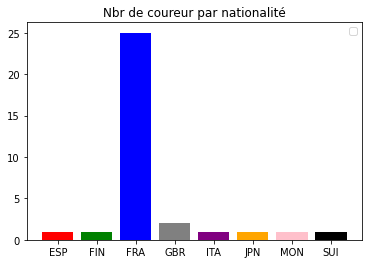

In [20]:
plt.bar(group_natio.index.tolist(), group_natio.values.tolist(), color = colour)
plt.title("Nbr de coureur par nationalité")
plt.legend()
plt.show()

**La repartition des foils :**

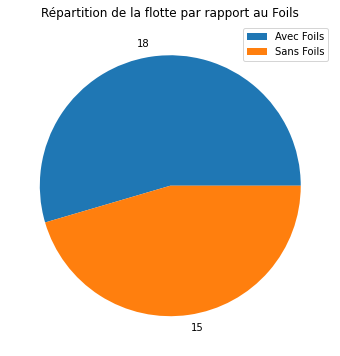

In [21]:
repartition_foils=df_boats['Nombre de dérives'].value_counts()
plt.figure(figsize = (6, 6))
plt.title("Répartition de la flotte par rapport au Foils")
plt.pie(repartition_foils.tolist(),
        labels = repartition_foils.tolist())
plt.legend (["Avec Foils","Sans Foils"])

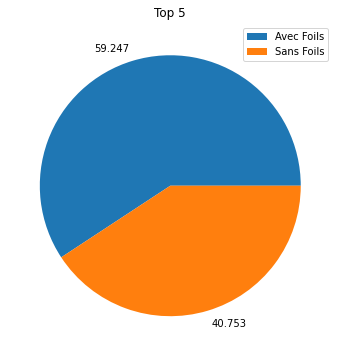

In [22]:
aa = df_merge.loc[df_merge["Rang"]<6]['Nombre de dérives'].value_counts().tolist()

bb = aa[0] / (aa[0] + aa[1])
cc = aa[1] / (aa[0] + aa[1])

dd = [round(bb*100, 3), round(cc*100, 3)]

plt.figure(figsize = (6, 6))
plt.title("Top 5")
plt.pie(dd,
        labels = dd)
plt.legend (["Avec Foils","Sans Foils"])


L'avantage de du foil semble non pertinent sur les résultats de la course (peut-être l'avantage augmente l'avarice des coureurs et les pousses à la faute). Des bateaux plus vieux et technologiquement moins avancés réussissent à finir parmi le top 5.

**Matrice de corrélation sur les dimensions des bateaux et le rang**

In [23]:
df_dim_boats = df_boats[["Identifiant","Largeur", "Longueur", "Tirant d'eau", "Déplacement (poids)", "Hauteur mât", "Surface de voiles au près"]]


In [24]:
df_dim_boats = df_dim_boats.drop(25)

In [25]:
df_dim_boats['Identifiant'] = df_dim_boats['Identifiant'].astype(int)

In [26]:
df_dim_boats.sort_values(by=['Identifiant']).head()

,Identifiant,Largeur,Longueur,Tirant d'eau,Déplacement (poids),Hauteur mât,Surface de voiles au près
20,1,5.9,18.28,4.5,8.0,28.0,300.0
31,2,5.5,18.28,4.5,7.8,28.0,270.0
28,4,5.7,18.28,4.5,8.0,29.0,260.0
32,6,5.7,18.28,4.5,7.9,27.3,270.0
24,7,5.9,18.28,4.5,0.0,27.0,290.0


In [27]:
df_rang_identifiant = pd.DataFrame(df_new.loc[df_new['Rang']]['Identifiant'].tail(25))
df_rang_identifiant['Identifiant'] = df_rang_identifiant['Identifiant'].astype(int)

In [28]:
liste_rang = df_rang_identifiant.sort_values(by=['Identifiant']).index

In [29]:
df_rang_identifiant = df_rang_identifiant.sort_values(by=['Identifiant'])

In [30]:
df_rang_identifiant['Rang'] = liste_rang

In [31]:
df_dim_boats = df_dim_boats.sort_values(by=['Identifiant'])

In [32]:
df_dim_boats = df_dim_boats.merge(df_rang_identifiant, how='left', on='Identifiant')
df_dim_boats = df_dim_boats.dropna()

In [33]:
df_dim_boats = df_dim_boats.drop(columns=['Identifiant'])

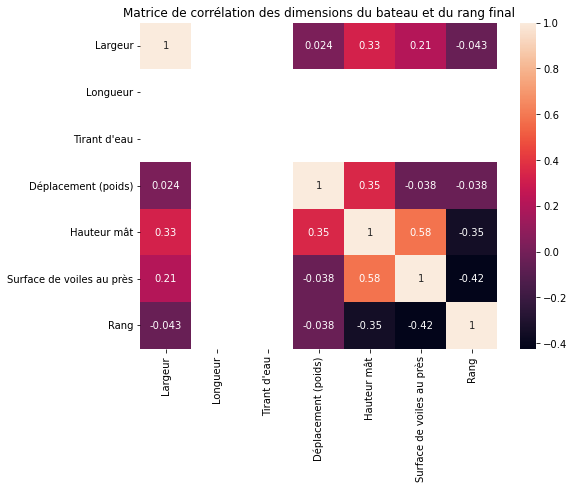

In [34]:
####################################
###### Matrice de corrélation ######
####################################
corr_df = df_dim_boats.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.title("Matrice de corrélation des dimensions du bateau et du rang final")
plt.show()

(Les valeurs longueur et Tirant d'eau sont tous les mêmes)

On ne remarque aucune corrélation entre les divers éléments du bateau et le rang.

Il semble que les performances sont à chercher ailleurs comme les capacités technique du navigateur, ou la preparation en amont des équipes ....

### <span style="color:orange">1. Régression linéaire entre le classement (rang) et la vitesse utile (VMG) des voiliers.

Pour répondre à cette problématique nous chercherons d'abbord à définir la moyenne des classements et la moyenne des vitesses utiles de chacun des voiliers.


In [35]:
#############################################################################################
## Création du dictionnaire du rang moyen et de la VMG moyenne pour chacun des participant ##
#############################################################################################

dico = {}

for i in liste_participant:
    dico[i] = {}

for i in liste_participant:
    liste_rang = []
    for j in df_new.loc[df_new['Skipper'] == i]['Rang'] :
       liste_rang.append(int(j)) 
    
    dico[i]['Rang moyen'] = sum(liste_rang)/len(liste_rang)
    
    liste_vmg = []
    for k in df_new.loc[df_new['Skipper'] == i]['Vitesse Depuis 24h (kts)']:
        liste_vmg.append(k)
    
    dico[i]['VMG moyen'] = sum(liste_vmg) / len(liste_vmg)

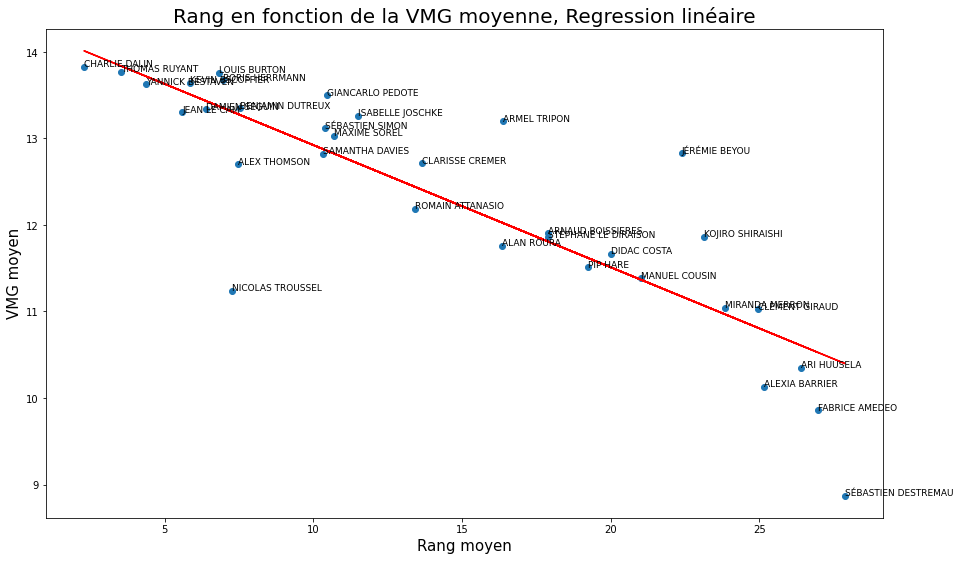

In [36]:
##### Plot du dictionnaire ######

# repackage les données
data = {"x":[], "y":[], "label":[]}
for label, coord in dico.items():
    data["x"].append(coord['Rang moyen'])
    data["y"].append(coord['VMG moyen'])
    data["label"].append(label)

model = LinearRegression()
model.fit(np.array(data["x"]).reshape(-1, 1),np.array(data["y"]).reshape(-1, 1))

# Regression
y_pred = model.predict(np.array(data["x"]).reshape(-1, 1))


# Affiche le plot
plt.figure(figsize=(15,9))
plt.title('Rang en fonction de la VMG moyenne, Regression linéaire', fontsize=20)
plt.xlabel('Rang moyen', fontsize=15)
plt.ylabel('VMG moyen', fontsize=15)
plt.scatter(data["x"], data["y"], marker = 'o')
plt.plot(data["x"], y_pred, color = 'red')

# add labels
for label, x, y in zip(data["label"], data["x"], data["y"]):
    plt.annotate(label, xy = (x, y), size = 9)

plt.show()

On peut remarquer que le classement correspond plutot bien à la vitesse des bateaux.

Leur connaissance et la preparation de leur trajet étant les mêmes, il semble logique que la vitesse soit l'un des elements clef qui risques de les départager.

Le cas Nicolas Troussel est un peu à part car il a abandonné la course suite à la casse de son mât.

### <span style="color:orange">2. Analyse descriptive - Observation de l'evolution des skippers

On propose une fonction qui permet de voir l'évolution des rangs au fil du temps.

In [37]:
df_rang = (pd.DataFrame(df_new[['Rang', 'Temps', 'Skipper', 'DTL (nm)']])).sort_values('Temps')
df_rang['Rang'] = df_rang['Rang'].astype(int)

In [38]:
def afficher_n_personne(liste_participant):
    plt.subplots(figsize=(15, 7))
    plt.title("Evolution du rang au cours du temps")

    
    for i in liste_participant:
        rang = df_rang['Rang'].loc[df_rang['Skipper'] == i]
        dates = df_rang['Temps'].loc[df_rang['Skipper'] == i]
        plt.plot(dates, rang, label =i)
   

    plt.xlabel("Dates") 
    plt.ylabel("Rang")
    plt.legend(loc="best")

    return

Les 4 premiers à avoir terminé la course nous ont offert une prestation remarquable.

Regardons un peu l'historique de leurs rangs ; observons leur performance !!

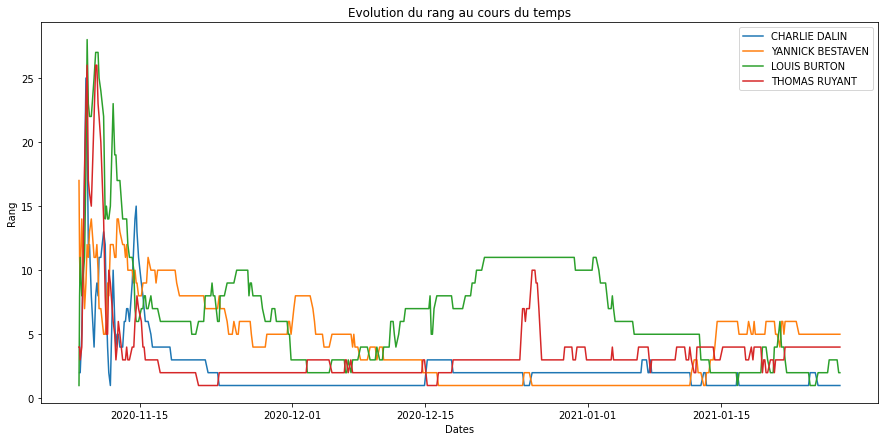

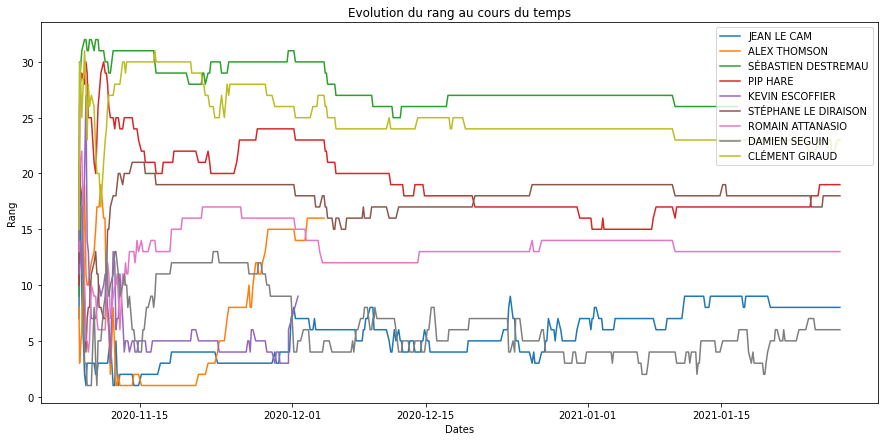

In [39]:
top4 = ['CHARLIE DALIN', 'YANNICK BESTAVEN', 'LOUIS BURTON', 'THOMAS RUYANT']
# Suivont nos champions de la course et observons comment ils se sot battu pour en arriver là
afficher_n_personne(top4)


# Tâchons de garder un oeil sur le reste des participants
afficher_n_personne(liste_participant[6:15])

La plupart des participants ont conservé un rang proche du début à la fin de la course.

Néanmoins la fin de course fut disputée les places ont pas mal été battu à la fin.

Une mention honorable à Louis Burton qui organisa une belle remontée!!


In [40]:
def DTL(liste_participant):
    plt.subplots(figsize=(15, 7))
    plt.title("Evolution du DTL au cours du temps")

    
    for i in liste_participant:
        rang = df_rang['DTL (nm)'].loc[df_rang['Skipper'] == i]
        dates = df_rang['Temps'].loc[df_rang['Skipper'] == i]
        plt.plot(dates, rang, label =i)
   

    plt.xlabel("Dates") 
    plt.ylabel("DTL")
    plt.legend()

    return

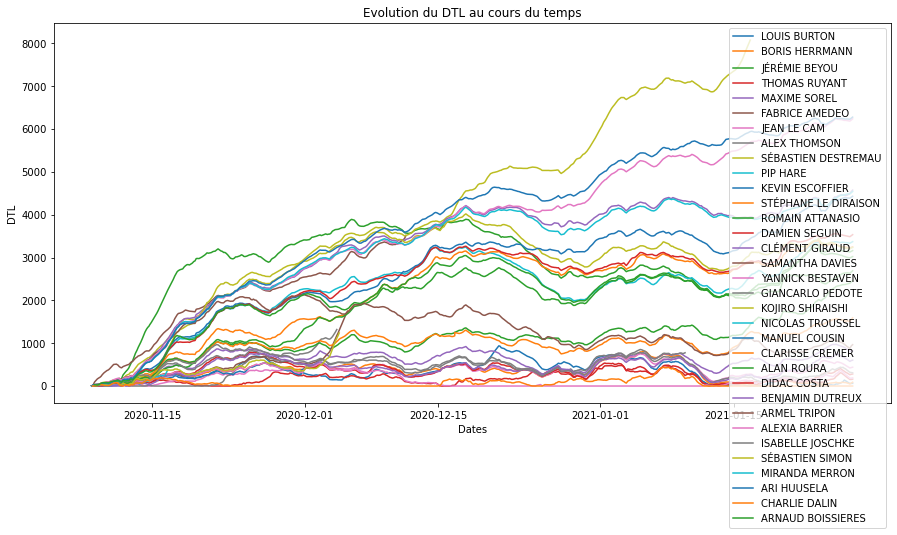

In [41]:
DTL(liste_participant)

### <span style="color:orange">3. Cartes avec le parcours d'un ou plusieurs bateaux

On va commencer par créer un data frame contenant les informations qui nous intéressent.

**AVIS A TOUS LES RETARDATAIRE ; AUJOURD'HUI JE VOUS PROPOSE DE REVIVRE LA COURSE DE VOS SKIPPERS PREFEREES** 

In [42]:
df_parcour = pd.DataFrame(df_new[['Rang', 'Temps', 'Skipper', 'Latitude', 'Longitude']])

In [43]:
df_parcour.head()

,Rang,Temps,Skipper,Latitude,Longitude
0,1,2020-11-08 15:30:00,LOUIS BURTON,46°24.46'N,01°50.48'W
1,2,2020-11-08 15:31:00,BORIS HERRMANN,46°24.34'N,01°49.82'W
2,3,2020-11-08 15:30:00,JÉRÉMIE BEYOU,46°24.91'N,01°49.99'W
3,4,2020-11-08 15:30:00,THOMAS RUYANT,46°24.71'N,01°49.68'W
4,5,2020-11-08 15:30:00,MAXIME SOREL,46°24.59'N,01°49.56'W


On récupère la fonction donnée dans le projet 2.

Nous l'utiliserons pour convertir les valeurs de latitude et de longitude.

In [44]:
# conversion degrés, minutes, secondes => décimal
def dms2dec(deg, mn, sec):
    return deg + mn / 60 + sec / 3600

In [45]:
############################
######## Conversion ########
############################

df_parcour['Latitude'] = df_parcour['Latitude'].apply(lambda x : (re.split("[°.']", x)[0:4])).apply(lambda x : dms2dec(deg = float(x[0]), mn = float(x[1]), sec = float(x[2])) if 'N' in str(x) else dms2dec(deg = - float(x[0]), mn = float(x[1]), sec = float(x[2])))
df_parcour['Longitude'] = df_parcour['Longitude'].apply(lambda x : (re.split("[°.']", x)[0:4])).apply(lambda x : dms2dec(deg = float(x[0]), mn = float(x[1]), sec = float(x[2])) if 'E' in str(x) else dms2dec(deg = - float(x[0]), mn = float(x[1]), sec = float(x[2])))

In [46]:
df_parcour.head()

,Rang,Temps,Skipper,Latitude,Longitude
0,1,2020-11-08 15:30:00,LOUIS BURTON,46.412778,-0.153333
1,2,2020-11-08 15:31:00,BORIS HERRMANN,46.409444,-0.160556
2,3,2020-11-08 15:30:00,JÉRÉMIE BEYOU,46.425278,-0.155833
3,4,2020-11-08 15:30:00,THOMAS RUYANT,46.419722,-0.164444
4,5,2020-11-08 15:30:00,MAXIME SOREL,46.416389,-0.167778


In [47]:
###########################################################
##### Liste des longitude et Latitude pour un skipper #####
###########################################################

def liste_trajet_skipper(nom_skipper):
    lati = []
    longi = []

    for i in df_parcour.loc[df_parcour['Skipper'] == nom_skipper]['Latitude'] :
        lati.append(i)
    for j in df_parcour.loc[df_parcour['Skipper'] == nom_skipper]['Longitude'] :
        longi.append(j)
    
    return lati, longi

*(Pour des raisons de visibilité pour les téléspectateurs nous n'afficherons que 5 coureurs à la fois)*

<a id="revenir" />

[Vous pouvez choisir parmi la liste en cliquant sur ce texte](#liste_participant)

In [48]:
##########################
#### Liste à modifier ####
##########################

liste_skipper_remake = ['CHARLIE DALIN', 'YANNICK BESTAVEN', 'LOUIS BURTON', 'THOMAS RUYANT', 'JÉRÉMIE BEYOU']

##### Couleur à associer à chaque skipper, les mettre dans l'orde
couleur = ['red', 'turquoise', 'green', 'pink', 'black']


In [49]:
######### Dico des trajet par skipper #########
skipper_remake = {}
for i in liste_skipper_remake:
    skipper_remake[i] = liste_trajet_skipper(nom_skipper = i)

In [54]:

############## La commande %matplotib force l'affichage de tous les plot dans une fenetre exterieur ##############

%matplotlib

##################################################################################################################
####################################### Le programme doit être lancé mannuellement ###############################
####################################### Le code n'a pas besoin de modification ###################################
##################################################################################################################

def que_la_course_commence(liste_skipper_remake, skipper_remake, couleur):
    
    fig = plt.figure(figsize=(30, 9))

    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.stock_img()

    ## Création des label
    maillot = []
    for j in liste_skipper_remake:
        i = liste_skipper_remake.index(j)
        maillot.append(mlines.Line2D([], [], color=couleur[i], marker='1',
                                markersize=15, label=j))
        plt.legend(handles=maillot)


    # Script de la course
    for c in range(0, 500, 4):
        #for i in range(len(skipper_remake)):
        for j in liste_skipper_remake:
            i = liste_skipper_remake.index(j)
            plt.plot(skipper_remake[j][1][c-5:c], skipper_remake[j][0][c-5:c],  # longitude, latitude
                        color = couleur[i], linewidth=0.7, marker=',', alpha = 0.6,
                        transform=ccrs.Geodetic())

        # Save les images pour créer le GIF
        # plt.savefig('images/foo{}.png'.format(c))
    
        plt.pause(0.1)
        
    plt.show()



Using matplotlib backend: MacOSX


# <span style="color:#FF6767"> Que la course commence

In [55]:
que_la_course_commence(liste_skipper_remake, skipper_remake, couleur)

La carte est interactive en lançant le programme.

Le résultat final est ci-dessous.

![Map](Figure_1.png)


In [75]:
##############################################################
########## Réorganisation de la liste des images #############
##############################################################

import re

def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)] 
    return sorted(l, key=alphanum_key)

In [76]:
##############################################################
############### Création d'un Gif ############################
##############################################################

from PIL import Image
import glob

# Create the frames
frames = []
imgs = glob.glob("images/*.png")

imgs = natural_sort(imgs)

for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

# Save into a GIF file that loops forever
frames[0].save('png_to_gif.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)

![Gif programme course](png_to_gif.gif)



🎆🎆🎆🎆🎆  🎇🎇🎇🎇🎇🎇   🎆🎆🎆🎆🎆🎆  🎇🎇🎇🎇🎇🎇   🎆🎆🎆🎆🎆🎆    🎇🎇🎇🎇

## Bravo aux concurents pour leur performance sportive.

## Merci au téléspectateur d'avoir regardé cette course.

🎆🎆🎆🎆🎆 🎇🎇🎇🎇🎇🎇 🎆🎆🎆🎆🎆🎆  🎇🎇🎇🎇🎇🎇   🎆🎆🎆🎆🎆🎆  🎇🎇🎇🎇